In [ ]:
!pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9155 sha256=c67fb5fed687cb5c8def298a9175c279a52bc0b6dd1d971ce3a4ee4fd6d295bf
  Stored in directory: /root/.cache/pip/wheels/bf/5e/dd/9670c2d20867bcff6eb19199822f6b32f16bbe01bea1cd35a8
Successfully built tensorflow-determinism


In [ ]:
from shutil import copyfile
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os 
import random
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
df = pd.read_csv("data2022_train.csv")
df = df.set_axis(["Date","y"], axis=1, inplace=False)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df = df.drop("Date",axis=1)

In [ ]:
df["sample"] = "train"
df["sample"].loc[df.index>="2017-11-01"] = "test"

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
y_mean = np.mean(df.loc[df["sample"]=="train","y"])
y_std = np.std(df.loc[df["sample"]=="train","y"])

df["y"] = (df["y"] - y_mean)/y_std

In [ ]:
def inv_diff(s,h0,p = 144):
  s0 = h0.append(s)
  n = len(s0)//p
  for i in range(n-1):
    s0[((i+1)*p):((i+2)*p)] = s0[((i)*p):((i+1)*p)].values + s0[((i+1)*p):((i+2)*p)].values
  return s0

In [ ]:
def transform_ts(df,r=30,shift=144,colname="y"):
  df_array = np.array([[np.nan]*(r)]*df.shape[0])
  df_array[:,0] = df[colname]
  for l in range(1,r):
    df_array[:,l] = df[colname].shift(l*shift)
  
  leadnames = ["y_{t+"+str(i*shift)+"}" for i in range(r-1,0,-1)]
  colnames = leadnames+["y_t"]
  final_df = pd.DataFrame(df_array,columns=colnames)
  final_df = final_df.dropna()
  final_df = final_df.loc[:,final_df.columns[::-1]]
  return np.reshape(final_df.values,(final_df.shape[0],final_df.shape[1],1))

In [ ]:
x_train = df[:(4320*5)][["y"]]
y_train = df[4320:4320*6][["y"]]

In [ ]:
x_val = df[4320*5:4320*9][["y"]]
y_val = df[4320*6:4320*10][["y"]]

In [ ]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y"]]
y_test = df[(4320*10+144*4):][["y"]]

In [ ]:
x_train_df = transform_ts(x_train,r=4320,shift=1)[:-1,:,:]
y_train_df = transform_ts(y_train,r=4320,shift=1)[:-1,:,:]
x_val_df = transform_ts(x_val,r=4320,shift=1)[:-1,:,:]
y_val_df = transform_ts(y_val,r=4320,shift=1)[:-1,:,:]
x_test_df = transform_ts(x_test,r=4320,shift=1).repeat(144,axis=0)
y_test_df = transform_ts(y_test,r=4320,shift=1).repeat(144,axis=0)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [ ]:
train_dataset = train_dataset.batch(144)
val_dataset = val_dataset.batch(144)
test_dataset = test_dataset.batch(144)

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [ ]:
learning_rate = 0.001
epochs = 5

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=144)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(4320)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(144, 4320, 1)]          0         
                                                                 
 gru_22 (GRU)                (144, 4320, 16)           912       
                                                                 
 gru_23 (GRU)                (144, 16)                 1632      
                                                                 
 dense_11 (Dense)            (144, 4320)               73440     
                                                                 
Total params: 75,984
Trainable params: 75,984
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/5
120/120 [==============================] - 41s 321ms/step - loss: 0.7324 - val_loss: 0.7825
Epoch 2/5
120/120 [==============================] - 38s 318ms/step - loss: 0.6638 - val_loss: 0.7845
Epoch 3/5
120/120 [==============================] - 37s 309ms/step - loss: 0.5867 - val_loss: 0.7833
Epoch 4/5
120/120 [==============================] - 39s 322ms/step - loss: 0.4942 - val_loss: 0.7947
Epoch 5/5
120/120 [==============================] - 41s 345ms/step - loss: 0.4380 - val_loss: 0.8178


In [ ]:
y_pred = net.predict(test_dataset)
y_test["pred"] = y_pred[0,:]
y_test_adj = y_test*y_std+y_mean

1/1 [==============================] - 1s 666ms/step


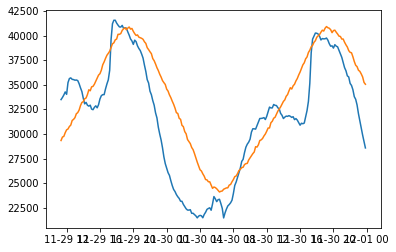

In [ ]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [ ]:
mae(y_test_adj["y"],y_test_adj["pred"])

2997.896240980613

In [ ]:
pred_month = y_test_adj["pred"]

Vettore con tutte le (30) 00:00:10 di gennaio per prevedere tutte quelle di febbraio (30)


In [ ]:
x_train_1 = df[:(4320)][["y"]]
y_train_1 = df[(4320):(4320*2)][["y"]]

x_train_2 = df[(4320):(4320*2)][["y"]]
y_train_2 = df[(4320*2):(4320*3)][["y"]]

x_train_3 = df[(4320*2):(4320*3)][["y"]]
y_train_3 = df[(4320*3):(4320*4)][["y"]]

x_train_4 = df[(4320*3):(4320*4)][["y"]]
y_train_4 = df[(4320*4):(4320*5)][["y"]]

x_train_5 = df[4320*4:4320*5][["y"]]
y_train_5 = df[4320*5:4320*6][["y"]]

In [ ]:
x_val_1 = df[4320*5:4320*6][["y"]]
y_val_1 = df[4320*6:4320*7][["y"]]

x_val_2 = df[4320*6:4320*7][["y"]]
y_val_2 = df[4320*7:4320*8][["y"]]

x_val_3 = df[4320*7:4320*8][["y"]]
y_val_3 = df[4320*8:4320*9][["y"]]

x_val_4 = df[4320*8:4320*9][["y"]]
y_val_4 = df[4320*9:4320*10][["y"]]

In [ ]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y"]]
y_test = df[(4320*10+144*4):][["y"]]

In [ ]:
x_train_df = np.concatenate((transform_ts(x_train_1),
                            transform_ts(x_train_2),
                            transform_ts(x_train_3),
                            transform_ts(x_train_4),
                            transform_ts(x_train_5)),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1),
                            transform_ts(y_train_2),
                            transform_ts(y_train_3),
                            transform_ts(y_train_4),
                            transform_ts(y_train_5)),axis=0)



In [ ]:
x_train_df.shape

(720, 30, 1)

In [ ]:
x_val_df = np.concatenate((transform_ts(x_val_1),
                          transform_ts(x_val_2),
                          transform_ts(x_val_3),
                          transform_ts(x_val_4)),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1),
                          transform_ts(y_val_2),
                          transform_ts(y_val_3),
                          transform_ts(y_val_4)),axis=0)



In [ ]:
x_val_df.shape

(576, 30, 1)

In [ ]:
x_test_df = transform_ts(x_test)
y_test_df = transform_ts(y_test)

In [ ]:
x_test_df.shape

(144, 30, 1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [ ]:
train_dataset = train_dataset.batch(24)
val_dataset = val_dataset.batch(24)
test_dataset = test_dataset.batch(24)

In [ ]:
learning_rate = 0.001
epochs =30

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [ ]:
# Architecture definition v2


inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=24)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(30)(x)
x = keras.layers.Reshape([30, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(24, 30, 1)]             0         
                                                                 
 gru_24 (GRU)                (24, 30, 16)              912       
                                                                 
 gru_25 (GRU)                (24, 16)                  1632      
                                                                 
 dense_12 (Dense)            (24, 30)                  510       
                                                                 
 reshape_10 (Reshape)        (24, 30, 1)               0         
                                                                 
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/30
30/30 [==============================] - 3s 26ms/step - loss: 0.7295 - val_loss: 0.6758
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5619 - val_loss: 0.5195
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.4012 - val_loss: 0.4433
Epoch 4/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3228 - val_loss: 0.4073
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2829 - val_loss: 0.3922
Epoch 6/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2623 - val_loss: 0.3844
Epoch 7/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2497 - val_loss: 0.3796
Epoch 8/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2413 - val_loss: 0.3775
Epoch 9/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2356 - val_loss: 0.3766
Epoch 10/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2325 - val_loss: 0.3758
Epoch 11/30
30/30 

In [ ]:
y_pred = net.predict(test_dataset)

6/6 [==============================] - 1s 3ms/step


In [ ]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_test["pred"] = pred_arr
y_test_adj = y_test*y_std+y_mean

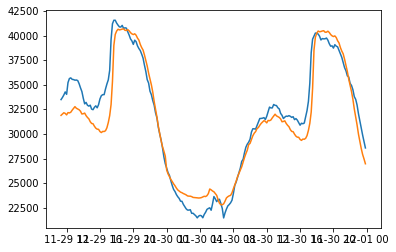

In [ ]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [ ]:
mae(y_test_adj["y"],y_test_adj["pred"])

1762.412454993648

In [ ]:
pred_day = y_test_adj["pred"]

Previsioni su Diff Y

In [ ]:
h0 = df["y"][0:144]
df["y_d"] = df["y"].diff(144)

In [ ]:
x_train = df[144:(4320*5)][["y_d"]]
y_train = df[(4320+144):4320*6][["y_d"]]

In [ ]:
x_val = df[4320*5:4320*9][["y_d"]]
y_val = df[4320*6:4320*10][["y_d"]]

In [ ]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y_d"]]
y_test = df[(4320*10+144*4):][["y_d"]]

In [ ]:
x_train_df = transform_ts(x_train,r=4320,shift=1,colname="y_d")[:-1,:,:]
y_train_df = transform_ts(y_train,r=4320,shift=1,colname="y_d")[:-1,:,:]
x_val_df = transform_ts(x_val,r=4320,shift=1,colname="y_d")[:-1,:,:]
y_val_df = transform_ts(y_val,r=4320,shift=1,colname="y_d")[:-1,:,:]
x_test_df = transform_ts(x_test,r=4320,shift=1,colname="y_d").repeat(144,axis=0)
y_test_df = transform_ts(y_test,r=4320,shift=1,colname="y_d").repeat(144,axis=0)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [ ]:
train_dataset = train_dataset.batch(144)
val_dataset = val_dataset.batch(144)
test_dataset = test_dataset.batch(144)

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [ ]:
learning_rate = 0.001
epochs = 5

In [ ]:
# Architecture definition v2

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=144)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(4320)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(144, 4320, 1)]          0         
                                                                 
 gru_26 (GRU)                (144, 4320, 16)           912       
                                                                 
 gru_27 (GRU)                (144, 16)                 1632      
                                                                 
 dense_13 (Dense)            (144, 4320)               73440     
                                                                 
Total params: 75,984
Trainable params: 75,984
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/5
119/119 [==============================] - 40s 319ms/step - loss: 0.1866 - val_loss: 0.1917
Epoch 2/5
119/119 [==============================] - 37s 308ms/step - loss: 0.1859 - val_loss: 0.1915
Epoch 3/5
119/119 [==============================] - 36s 307ms/step - loss: 0.1858 - val_loss: 0.1914
Epoch 4/5
119/119 [==============================] - 37s 309ms/step - loss: 0.1858 - val_loss: 0.1914
Epoch 5/5
119/119 [==============================] - 37s 312ms/step - loss: 0.1857 - val_loss: 0.1914


In [ ]:
y_pred = net.predict(test_dataset)

1/1 [==============================] - 1s 636ms/step


In [ ]:
y_d = df["y_d"]


<ipython-input-292-ed104b904c84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_d[-4320:]=y_pred[0,:]


In [ ]:
y_d[-4320:]=y_pred[0,:]
inv_pred = inv_diff(y_d.dropna(),h0)

y_test["pred"] = inv_pred[-4320:]
y_test["y"] = df["y"][-4320:]
y_test_adj = y_test*y_std+y_mean

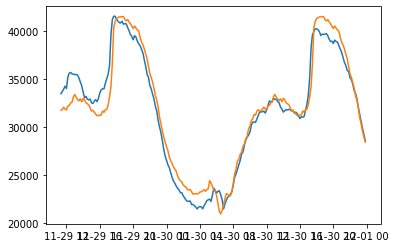

In [ ]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [ ]:
mae(y_test_adj["y"],y_test_adj["pred"])

1529.426451512702

In [ ]:
pred_diffmonth = y_test_adj["pred"]

In [ ]:
import random
import os

In [ ]:
x_train_1 = df[144:(4320)][["y_d"]]
y_train_1 = df[(4320+144):(4320*2)][["y_d"]]

x_train_2 = df[(4320):(4320*2)][["y_d"]]
y_train_2 = df[(4320*2):(4320*3)][["y_d"]]

x_train_3 = df[(4320*2):(4320*3)][["y_d"]]
y_train_3 = df[(4320*3):(4320*4)][["y_d"]]

x_train_4 = df[(4320*3):(4320*4)][["y_d"]]
y_train_4 = df[(4320*4):(4320*5)][["y_d"]]

x_train_5 = df[4320*4:4320*5][["y_d"]]
y_train_5 = df[4320*5:4320*6][["y_d"]]

x_val_1 = df[4320*5:4320*6][["y_d"]]
y_val_1 = df[4320*6:4320*7][["y_d"]]


In [ ]:

x_val_2 = df[4320*6:4320*7][["y_d"]]
y_val_2 = df[4320*7:4320*8][["y_d"]]

x_val_3 = df[4320*7:4320*8][["y_d"]]
y_val_3 = df[4320*8:4320*9][["y_d"]]

x_val_4 = df[4320*8:4320*9][["y_d"]]
y_val_4 = df[4320*9:4320*10][["y_d"]]

In [ ]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y_d"]]
y_test = df[(4320*10+144*4):][["y_d"]]

In [ ]:
x_train_df = np.concatenate((transform_ts(x_train_1,colname="y_d"),
                            transform_ts(x_train_2,colname="y_d"),
                            transform_ts(x_train_3,colname="y_d"),
                            transform_ts(x_train_4,colname="y_d"),
                            transform_ts(x_train_5,colname="y_d")),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1,colname="y_d"),
                            transform_ts(y_train_2,colname="y_d"),
                            transform_ts(y_train_3,colname="y_d"),
                            transform_ts(y_train_4,colname="y_d"),
                            transform_ts(y_train_5,colname="y_d")),axis=0)



In [ ]:
x_val_df = np.concatenate((transform_ts(x_val_1,colname="y_d"),
                          transform_ts(x_val_2,colname="y_d"),
                          transform_ts(x_val_3,colname="y_d"),
                          transform_ts(x_val_4,colname="y_d")),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1,colname="y_d"),
                          transform_ts(y_val_2,colname="y_d"),
                          transform_ts(y_val_3,colname="y_d"),
                          transform_ts(y_val_4,colname="y_d")),axis=0)



In [ ]:
x_test_df = transform_ts(x_test,colname="y_d")
y_test_df = transform_ts(y_test,colname="y_d")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [ ]:
train_dataset = train_dataset.batch(72)
val_dataset = val_dataset.batch(72)
test_dataset = test_dataset.batch(72)

In [ ]:
learning_rate = 0.001
epochs = 30

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch


In [ ]:
glo_init = tf.keras.initializers.GlorotUniform(seed=1)
ort_init= tf.keras.initializers.Orthogonal(seed=1)

In [ ]:

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=72)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(30)(x)
x = keras.layers.Reshape([30, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(72, 30, 1)]             0         
                                                                 
 gru_80 (GRU)                (72, 30, 16)              912       
                                                                 
 gru_81 (GRU)                (72, 16)                  1632      
                                                                 
 dense_36 (Dense)            (72, 30)                  510       
                                                                 
 reshape_33 (Reshape)        (72, 30, 1)               0         
                                                                 
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/30
8/8 [==============================] - 3s 86ms/step - loss: 0.1962 - val_loss: 0.1928
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.1943 - val_loss: 0.1936
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1934 - val_loss: 0.1940
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1929 - val_loss: 0.1944
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 0.1924 - val_loss: 0.1949
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1921 - val_loss: 0.1954
Epoch 7/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1918 - val_loss: 0.1958
Epoch 8/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1916 - val_loss: 0.1961
Epoch 9/30
8/8 [==============================] - 0s 10ms/step - loss: 0.1914 - val_loss: 0.1965
Epoch 10/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1911 - val_loss: 0.1968
Epoch 11/30
8/8 [===================

In [ ]:
y_pred = net.predict(test_dataset)

2/2 [==============================] - 1s 7ms/step


In [ ]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_d = df["y_d"]
y_d[-4320:]=pred_arr

inv_pred = inv_diff(y_d.dropna(),h0)

y_test["pred"] = inv_pred[-4320:]
y_test["y"] = df["y"][-4320:]

y_test_adj = y_test*y_std+y_mean


<ipython-input-540-55644380403a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_d[-4320:]=pred_arr


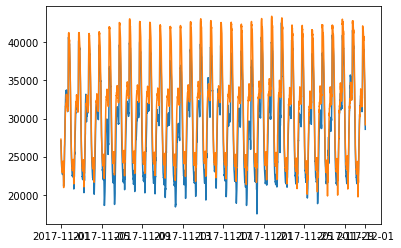

In [ ]:
plt.plot(y_test_adj["y"])
plt.plot(y_test_adj["pred"])

In [ ]:
mae(y_test_adj["y"],y_test_adj["pred"])

2174.222626172813

In [ ]:
pred_diffday = y_test_adj["pred"]

In [ ]:
pred_df = pd.DataFrame({"month":pred_month,"day":pred_day,"diffmonth":pred_diffmonth,"diffday":pred_diffday})

In [ ]:
pred_df.to_csv("pred_lstm.csv")

In [ ]:
h0 = df["y"][0:144]
df["y_d"] = df["y"].diff(144)

In [ ]:
x_train_1 = df[144:(4608)][["y_d"]]
y_train_1 = df[(4608):(9072)][["y_d"]]

x_train_2 = df[(4608):(9072)][["y_d"]]
y_train_2 = df[(9072):(13536)][["y_d"]]

x_train_3 = df[(9072):(13536)][["y_d"]]
y_train_3 = df[(13536):(18000)][["y_d"]]

x_train_4 = df[(13536):(18000)][["y_d"]]
y_train_4 = df[(18000):(22464)][["y_d"]]

x_train_5 = df[(18000):(22464)][["y_d"]]
y_train_5 = df[(22464):(26928)][["y_d"]]

x_train_6 = df[(22464):(26928)][["y_d"]]
y_train_6 = df[(26928):(31392)][["y_d"]]


In [ ]:
x_val_1 = df[(26928):(31392)][["y_d"]]
y_val_1 = df[(31392):(35856)][["y_d"]]

x_val_2 = df[(31392):(35856)][["y_d"]]
y_val_2 = df[(35856):(40320)][["y_d"]]

x_val_3 = df[(35856):(40320)][["y_d"]]
y_val_3 = df[(40320):(44784)][["y_d"]]


In [ ]:
x_test = df[-4464:][["y_d"]]

In [ ]:
x_train_df = np.concatenate((transform_ts(x_train_1,r=31,colname="y_d"),
                            transform_ts(x_train_2,r=31,colname="y_d"),
                            transform_ts(x_train_3,r=31,colname="y_d"),
                            transform_ts(x_train_4,r=31,colname="y_d"),
                            transform_ts(x_train_5,r=31,colname="y_d"),
                            transform_ts(x_train_6,r=31,colname="y_d")),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1,r=31,colname="y_d"),
                            transform_ts(y_train_2,r=31,colname="y_d"),
                            transform_ts(y_train_3,r=31,colname="y_d"),
                            transform_ts(y_train_4,r=31,colname="y_d"),
                            transform_ts(y_train_5,r=31,colname="y_d"),
                            transform_ts(y_train_6,r=31,colname="y_d")),axis=0)



In [ ]:
x_val_df = np.concatenate((transform_ts(x_val_1,r=31,colname="y_d"),
                          transform_ts(x_val_2,r=31,colname="y_d"),
                          transform_ts(x_val_3,r=31,colname="y_d")),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1,r=31,colname="y_d"),
                          transform_ts(y_val_2,r=31,colname="y_d"),
                          transform_ts(y_val_3,r=31,colname="y_d")),axis=0)



In [ ]:
x_test_df = transform_ts(x_test,r=31,colname="y_d")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df))

In [ ]:
train_dataset = train_dataset.batch(72)
val_dataset = val_dataset.batch(72)
test_dataset = test_dataset.batch(72)

In [ ]:
learning_rate = 0.001
epochs = 30

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch


In [ ]:

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=72)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(31)(x)
x = keras.layers.Reshape([31, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(72, 31, 1)]             0         
                                                                 
 gru_82 (GRU)                (72, 31, 16)              912       
                                                                 
 gru_83 (GRU)                (72, 16)                  1632      
                                                                 
 dense_37 (Dense)            (72, 31)                  527       
                                                                 
 reshape_34 (Reshape)        (72, 31, 1)               0         
                                                                 
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/30
12/12 [==============================] - 3s 100ms/step - loss: 0.1964 - val_loss: 0.1793
Epoch 2/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1952 - val_loss: 0.1795
Epoch 3/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1946 - val_loss: 0.1795
Epoch 4/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1943 - val_loss: 0.1795
Epoch 5/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1940 - val_loss: 0.1796
Epoch 6/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1937 - val_loss: 0.1797
Epoch 7/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1934 - val_loss: 0.1798
Epoch 8/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1932 - val_loss: 0.1798
Epoch 9/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1929 - val_loss: 0.1799
Epoch 10/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1925 - val_loss: 0.1800
Epoch 11/30
12/12

In [ ]:
y_pred = net.predict(test_dataset)

2/2 [==============================] - 1s 7ms/step


In [ ]:
y_pred.shape

(144, 31, 1)

array([        nan,         nan,         nan, ..., -0.08563788,
       -0.08255819, -0.08199397])

In [ ]:
y_d.values.dropna()

AttributeError: ignored

In [ ]:
pd.Series(y_d_pred)

0       -1.028925
1       -0.510211
2       -0.490653
3       -0.455788
4       -0.405617
           ...   
52411   -0.007501
52412   -0.010062
52413   -0.014738
52414   -0.015047
52415   -0.012696
Length: 52416, dtype: float64

In [ ]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_d = df["y_d"].dropna()
y_d_pred = np.append(y_d.values,pred_arr)

inv_pred = inv_diff(pd.Series(y_d_pred),h0)

y_test_adj = inv_pred*y_std+y_mean

In [ ]:
gru_dec=y_test_adj[-4464:]

In [ ]:
plt.plot(gru_dec)

In [ ]:
gru_dec = pd.DataFrame({"pred":gru_dec})

In [ ]:
gru_dec.to_csv("gru_dec.csv")